# Modeling of photovoltaic devices

This example demonstrates modeling of photovoltaic devices. Figures of merit, such as fill factor, are extracted from results of the simulation. For illustration, a [reference](https://dx.doi.org/10.1103/PhysRevB.85.155201) is partially reproduced.

Simulations like those shown above can show possible optimization oportunities for devices. They also can yield ultimate performance of idealized devices.

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
from oedes import *
init_notebook()
import scipy.interpolate
plt.rcParams['axes.formatter.useoffset']=False

## Model

We start with popular assumption that light is absorbed uniformly inside the device. The assumption can be justified for thin devices, and for white illumination.

In [2]:
def absorption(x):
    return 1.5e28

The base model consists in Poisson's equation coupled to the drift-diffusion equations for electrons and holes. Constant mobilities are assumed. Additionally, contacts can be defined as selective (blocking electrons and holes at "invalid" electrode"), or non-selective with local thermal equilibrium is assumed at any electrode for all charge carriers. 

In [3]:
def base_model(L=50e-9,selective=False):
    mesh = fvm.mesh1d(L)
    model = models.BaseModel()
    model.poisson = models.Poisson(mesh)
    model.poisson.bc = [models.AppliedVoltage(k) for k in mesh.boundaries]
    electron = models.add_transport(model, mesh, -1, 'electron')
    hole = models.add_transport(model, mesh, 1, 'hole')
    if selective:
        electron.bc = [models.FermiLevelEqualElectrode('electrode1') ]
        hole.bc = [models.FermiLevelEqualElectrode('electrode0') ]
    for p in ['electron', 'hole']:
        model.species_v_D[p] = models.species_v_D_charged_from_params
    return model,electron,hole

The basic model created by function above contains no recombination term, and must be suplemented with it. Complete models are created by functions below, with the following options for the recombination model:
- direct : $R=\beta \left(n p-n_i p_i \right)$
- Langevin: $R=\frac{\mu_n+\mu_p}{\varepsilon} \left(n p-n_i p_i \right)$
- Shockley-Reed-Hall recombination, in parallel with direct recombination

Absorption is assumed to create free electrons and holes directly.

In [4]:
def base_direct_absorption(*args,**kwargs):
    model,electron,hole = base_model(*args,**kwargs)
    model.sources.append(models.DirectGeneration([electron,hole],absorption))
    return model,electron,hole
def model_Langevin(*args,**kwargs):
    model,electron,hole=base_direct_absorption(*args,**kwargs)
    model.sources.append(models.LangevinRecombination(electron.mesh,electron.prefix,hole.prefix))
    model.setUp()
    return model
def model_const(*args, **kwargs):
    model,electron,hole=base_direct_absorption(*args,**kwargs)
    model.sources.append(models.DirectRecombination(electron.mesh,electron.prefix,hole.prefix))
    model.setUp()
    return model
def model_SRH(*args,**kwargs):
    model,electron,hole=base_direct_absorption(*args,**kwargs)
    model.sources.append(models.SRH(electron,hole,'srh'))
    model.sources.append(models.DirectRecombination(electron.mesh,electron.prefix,hole.prefix))
    model.setUp()
    return model    

Below is a procedure generating default simulation parameters. They are parametrized by the bandgap, by the (symmetric) barrier at the electrodes, and by SRH lifetime. Note that not all parameters are used at the same time, for example SRH parameters are not used by non-SRH models.

In [5]:
def make_params(barrier=0.3,bandgap=1.2,Nc=1e27,Nv=1e27,srh_tau=1e-8):
    srh_trate=1e-8
    default_params = {
        'T': 300.,
        'epsilon_r': 5.,
        'electron.mu': 1e-10,
        'hole.mu': 1e-10,
        'electron.N0': Nc,
        'hole.N0': Nv,
        'absorption.I': 1.,
        'exciton.absorption.I':1,
        'electron.level': 0.,
        'electrode0.workfunction': bandgap-barrier,
        'hole.level': bandgap,
        'electrode1.workfunction': barrier,
        'electrode0.voltage': 0.,
        'electrode1.voltage': 0.,
        'npi': Nc*Nv*exp(-1.2/functions.ThermalVoltage(300.)),
        'beta':7.23e-17,
        'electron.srh.trate':srh_trate,
        'hole.srh.trate':srh_trate,
        'srh.N0':1./(srh_tau*srh_trate),
        'srh.level':bandgap*0.5
    }
    return default_params

## Calculations

The function below takes I_V curve, which should include points V=0 and J=0, and calculates the open circuit voltage, the power at maximum power point, and the fill factor.

In [6]:
def performance(v,J):
    iv=scipy.interpolate.InterpolatedUnivariateSpline(v,J)
    Isc=iv(0.)
    Voc,=iv.roots()
    v=np.linspace(0,Voc)
    Pmax=np.amax(-v*iv(v))
    Ff=-Pmax/(Voc*Isc)
    return dict(Ff=Ff,Voc=Voc,Isc=Isc,Pmax=Pmax)

In the reference, the mobilities of electrons and holes are varied but kept equal. The following shows how such sweep can be implemented.

In [7]:
mu_values = np.logspace(-10,-2,19)
def mu_sweep(params):
    for mu in mu_values:
        p=dict(params)
        p['electron.mu']=mu
        p['hole.mu']=mu
        yield mu,p
v_sweep = sweep('electrode0.voltage',np.linspace(0.,0.8,40))

Because different models are considered below, a common function is defined here to run the simulation and to plot the result. The function takes model as an argument.

In [8]:
def Voc_Ff(model,params):
    c=context(model)
    result=[]
    def onemu(mu, cmu):
        for _ in cmu.sweep(cmu.params, v_sweep):
            pass
        v,J=cmu.teval(v_sweep.parameter_name,'J')
        p = performance(v,J)
        return (mu, p['Voc'], p['Ff'])
    result = np.asarray([onemu(*_) for _ in c.sweep(params, mu_sweep)])
    testing.store(result)
    fig,(ax_voc,ax_ff)=plt.subplots(nrows=2,sharex=True)
    ax_voc.plot(result[:,0],result[:,1])
    ax_ff.plot(result[:,0],result[:,2])
    ax_ff.set_xlabel(r'$\mu \mathrm{[m^2 V^{-1} s^{-1}]}$')
    ax_ff.set_xscale('log')
    ax_ff.set_ylabel('FF')
    ax_voc.set_ylabel('$V_{oc}$');    
    return result

In [9]:
params=make_params()

## Results

### Direct recombination, non-selective contacts

As seen below, in the case of direct recombination, selective contacts are useful for improving fill factor and open-circuit voltage regardless of mobilities. 

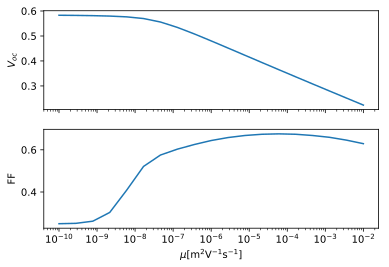

In [10]:
Voc_Ff(model_const(selective=False),params);

### Direct recombination, selective contacts

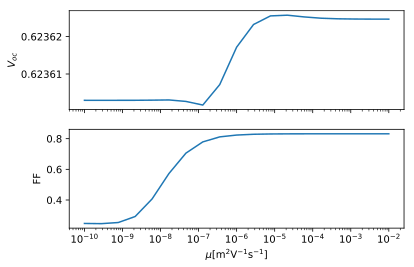

In [11]:
Voc_Ff(model_const(selective=True),params);

### Langevin recombination, non-selective contants

If Langevin recombination is assumed, open circuit voltage drops regardless of contact selectivity.

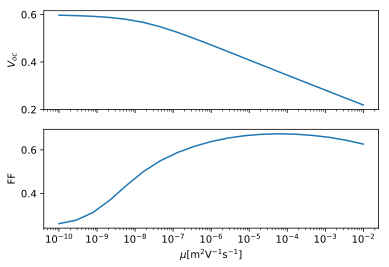

In [12]:
Voc_Ff(model_Langevin(selective=False),params);

### Langevin recombination, selective contants

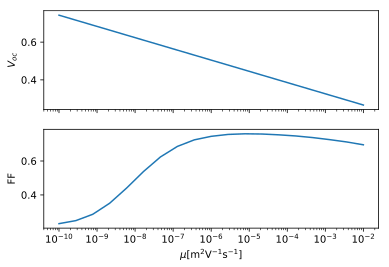

In [13]:
Voc_Ff(model_Langevin(selective=True),params);

### SRH recombination, non-selective contacts

The case of SRH recombination resembles the case of direct recombination in its dependence on mobility. This is not surprising, as in both cases the mobility does not enter the recombination term $R$.

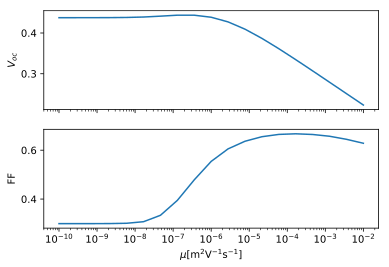

In [14]:
Voc_Ff(model_SRH(selective=False),params);

### SRH recombination, selective contacts

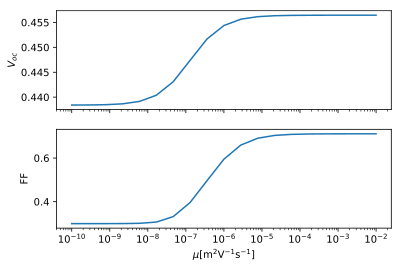

In [15]:
Voc_Ff(model_SRH(selective=True),params);

## Reference

Wolfgang Tress, Karl Leo, Moritz Riede, [Optimum mobility, contact properties, and open-circuit voltage of organic solar cells: A drift-diffusion simulation study](https://dx.doi.org/10.1103/PhysRevB.85.155201), Phys. Rev. B. 85155201 (2012))